In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense # type: ignore
from sklearn.model_selection import ParameterGrid
import multiprocessing as mp
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
data = pd.read_csv("sample_DATA_LSTM.csv")

# Convert TimeStamp to datetime and set as index
data['TimeStamp'] = pd.to_datetime(data['TimeStamp'])
data.set_index('TimeStamp', inplace=True)

# Ensure timestamps are complete with 3-minute intervals
data = data.resample('3T').mean()



# Handle missing values (interpolation)
data.interpolate(method='linear', inplace=True)
data.fillna(method='ffill', inplace=True)
data.dropna(inplace=True)
# for simflicity, we will only use the first 1000 rows
data = data.head(1000)

## Create a dataset with the first columns to train on
data_train = data[data.columns[0:1]]
# Create a dataset that the model would predict the model on 
data_predict = data[data.columns[1:]]

# Function that create Dataset of the LSTM

In [3]:
# Function to prepare the dataset for LSTM 
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# GridSerch

In [5]:
# Define the hyperparameter grid for the LSTM model
# 'param_grid' defines a grid of hyperparameters for the LSTM model.
# It contains the following keys:
# - 'units': Number of units (LSTM cells) in each LSTM layer. We test one value: 50.
# - 'batch_size': The number of training samples processed before the model updates its weights. We test batch size of 32.
# - 'epochs': Number of complete passes through the training dataset. We test 10 and 20 epochs.
# - 'time_step': The number of previous time steps (look-back window) used to predict the next time step. We test 5 and 10 time steps.
#   - If each index is in 3-minute intervals:
#     - 5 time steps = 15 minutes.
#     - 10 time steps = 30 minutes.

param_grid = {
    'units': [50, 100, 150],   # Test 50, 100, and 150 units
    'batch_size': [32, 64],    # Test with batch sizes of 32 and 64
    'epochs': [10, 20],        # Test with 10 and 20 epochs
    'time_step': [5, 10, 15]       # Test with 5 and 10 time steps
}
# there are 3*2*2*3 = 36 combinations of hyperparameters to test

# calculate the number of combinations based on the hyperparameter grid
num_combinations = len(param_grid['units']) * len(param_grid['batch_size']) * len(param_grid['epochs']) * len(param_grid['time_step'])


# Function to create dataset (X, y) based on time steps
def create_dataset(data, time_step):
    """
    Creates the dataset X, y based on the number of time steps (look-back window).
    
    Parameters:
    - data: The scaled data (numpy array).
    - time_step: The number of time steps (look-back window) to use for prediction.
    
    Returns:
    - X: Input features (previous time steps).
    - y: Target values (next time step).
    """
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Function to train and evaluate the model with specific parameters
def train_and_evaluate(params, column, scaled_data, scaler):
    """
    Train and evaluate the LSTM model with specific hyperparameters.
    
    Parameters:
    - params: Dictionary containing the current hyperparameters being tested.
    - column: The name of the column (time series) being processed.
    - scaled_data: Scaled data used for training and testing.
    - scaler: MinMaxScaler instance used for scaling and inverse transformation.
    
    Returns:
    - Dictionary containing the parameters, error (MAE), and training history.
    """
    # Print the current combination of hyperparameters with time logging format (HH:MM:SS)
    now = datetime.now().strftime("%H:%M:%S")
    print(f"\t{now} - Training {column} with hyperparameters: {params}")
    
    # Extract the time_step from params
    time_step = params['time_step']
    
    # Create the dataset using the time_step
    X, y = create_dataset(scaled_data, time_step)

    # Split the data into training and testing datasets
    train_size = int(len(scaled_data) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Reshape data to be in the format [samples, time steps, features] required by LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Build the LSTM model based on current hyperparameters
    model = Sequential()
    model.add(LSTM(params['units'], return_sequences=True, input_shape=(time_step, 1)))  # LSTM layer 1
    model.add(LSTM(params['units'], return_sequences=True))                             # LSTM layer 2
    model.add(LSTM(params['units']))                                                    # LSTM layer 3 (no return sequences)
    model.add(Dense(1))                                                                 # Dense layer (output layer)
    
    # Compile the model using mean squared error loss and Adam optimizer
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the model with given epochs and batch size
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)

    # Predict on the test data
    test_predict = model.predict(X_test)

    # Inverse transform the predictions and actual values to their original scale
    test_predict = scaler.inverse_transform(test_predict)
    y_test = scaler.inverse_transform([y_test])

    # Calculate prediction error (difference between predictions and actual values)
    error = np.mean(np.abs(test_predict.flatten() - y_test.flatten()))  # Use mean absolute error (MAE) as the evaluation metric
    now = datetime.now().strftime("%H:%M:%S")
    print(f"\t{now} -{column} error (MAE): {error}")
    # Return the results: parameters, error, and history
    return {'params': params, 'error': error, 'history': history.history, "model": model}

# Function to perform grid search on the first column of the data
def grid_search(data):
    """
    Perform grid search over the hyperparameter grid for the LSTM model.
    
    Parameters:
    - data: DataFrame containing the time series data.
    
    Returns:
    - predictions: Dictionary containing errors for each hyperparameter combination.
    - errors: Dictionary of MAE errors for each hyperparameter combination.
    - histories: Dictionary containing training histories for each hyperparameter combination.
    - best_params: The hyperparameters that achieved the lowest MAE.
    - best_error: The lowest validation MAE.
    """
    # Prepare to store results
    predictions = {}
    errors = {}
    histories = {}
    best_params = None
    best_error = float('inf')  # Initialize with a very high error value

    combination_counter = 0  # Initialize a counter for the hyperparameter combinations

    # Loop over the first column only
    for column in data.columns[:]:  # Restricting to the first column
        print(f"Processing column: {column}")
        # Scale the data for the column
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(data[[column]])

        # Loop over each combination of hyperparameters in the grid
        for params in ParameterGrid(param_grid):
            combination_counter += 1  # Increment the counter for each combination
            print(f"Processing combination {combination_counter}/{num_combinations} for column: {column}")
            
            # Train and evaluate the model with the current hyperparameters
            result = train_and_evaluate(params, column, scaled_data, scaler)

            # Store predictions, errors, and training histories
            predictions[(column, str(result['params']))] = result['error']
            errors[(column, str(result['params']))] = result['error']
            histories[(column, str(result['params']))] = result['history']
            
            # Check if the current result is better (i.e., has a lower error) than the previous best
            if result['error'] < best_error:
                best_error = result['error']
                best_params = result['params']
                best_model = result["model"]

    # Return predictions, errors, histories, and the best hyperparameters found
    return predictions, errors, histories, best_params, best_error, best_model

# Run the grid search and get the best hyperparameters for the first column
predictions, errors, histories, best_params, best_error, best_model = grid_search(data_train)

# Print the best hyperparameters and their corresponding error
print(f"\n\nBest hyperparameters: {best_params}")
print(f"Best validation error (MAE): {best_error}")

Processing column: A01a-Z0
Processing combination 1/36 for column: A01a-Z0
	12:18:41 - Training A01a-Z0 with hyperparameters: {'batch_size': 32, 'epochs': 10, 'time_step': 5, 'units': 50}
7/7 [==============================] - 1s 5ms/step
	12:18:53 -A01a-Z0 error (MAE): 0.21332369846304786
Processing combination 2/36 for column: A01a-Z0
	12:18:53 - Training A01a-Z0 with hyperparameters: {'batch_size': 32, 'epochs': 10, 'time_step': 5, 'units': 100}
7/7 [==============================] - 1s 7ms/step
	12:19:05 -A01a-Z0 error (MAE): 0.15842719631234514
Processing combination 3/36 for column: A01a-Z0
	12:19:05 - Training A01a-Z0 with hyperparameters: {'batch_size': 32, 'epochs': 10, 'time_step': 5, 'units': 150}
7/7 [==============================] - 1s 10ms/step
	12:19:20 -A01a-Z0 error (MAE): 0.08877637914913335
Processing combination 4/36 for column: A01a-Z0
	12:19:20 - Training A01a-Z0 with hyperparameters: {'batch_size': 32, 'epochs': 10, 'time_step': 10, 'units': 50}
6/6 [===========

#  learning curves from histories
### The `histories` object contains the training and validation metrics (such as loss or accuracy) over epochs for each hyperparameter combination at was tested during the grid search.
###  This is useful for analyzing how the model performed over time and for visualizing how the loss (or other metrics) decreased as the model trained.


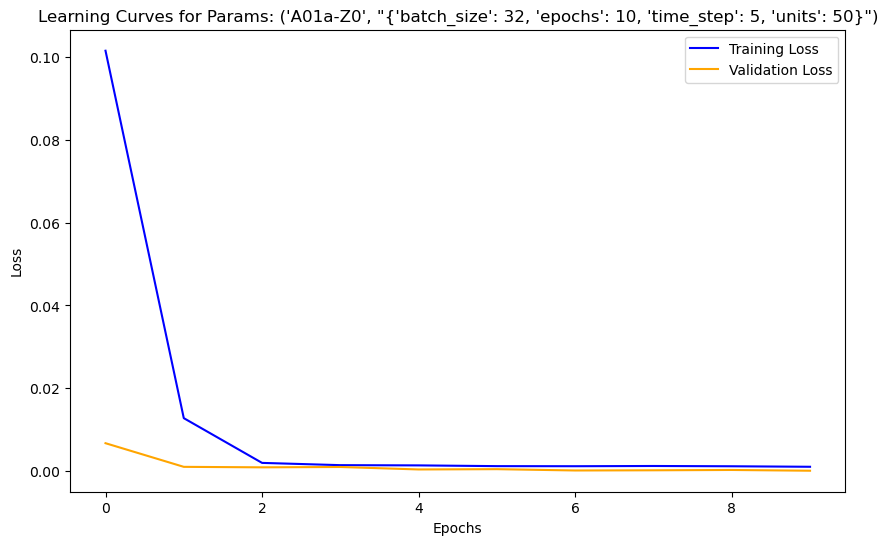

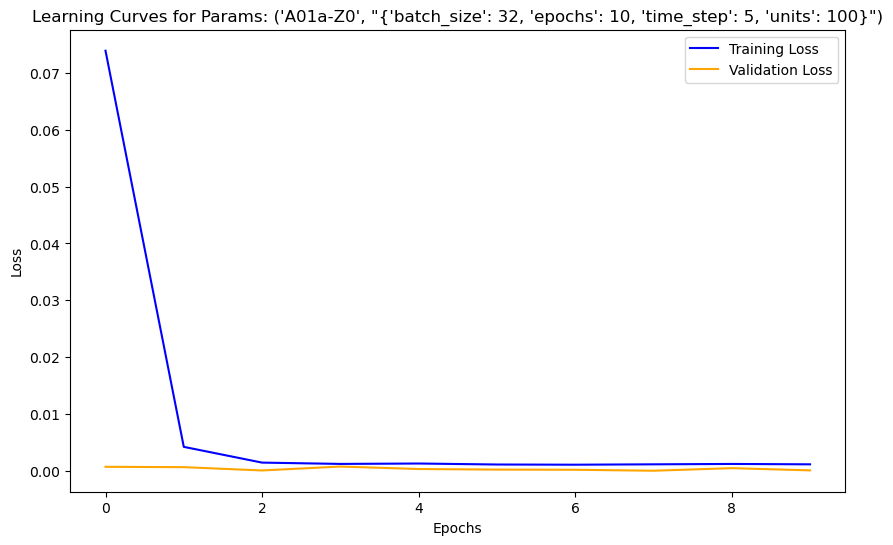

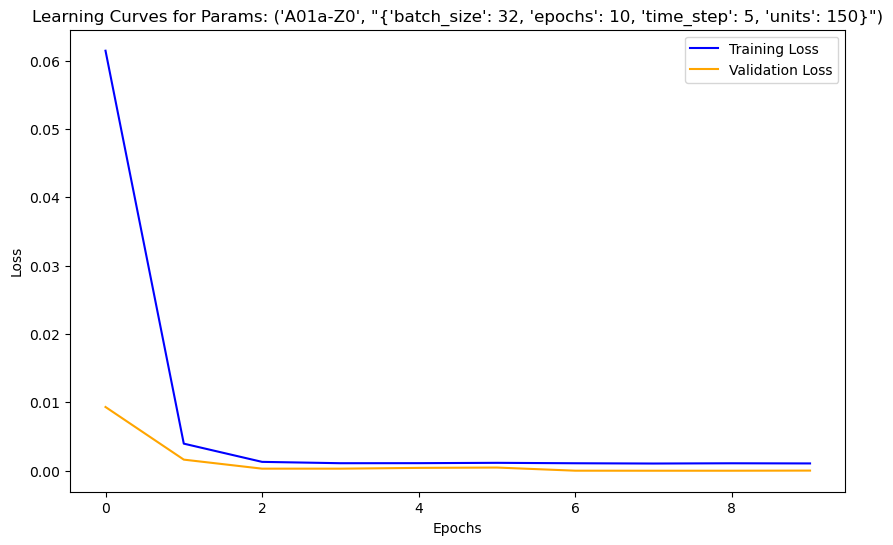

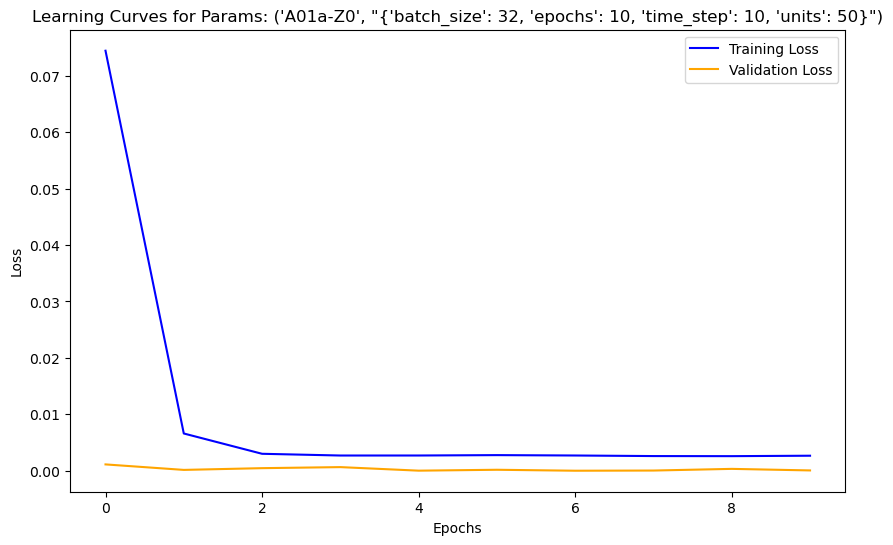

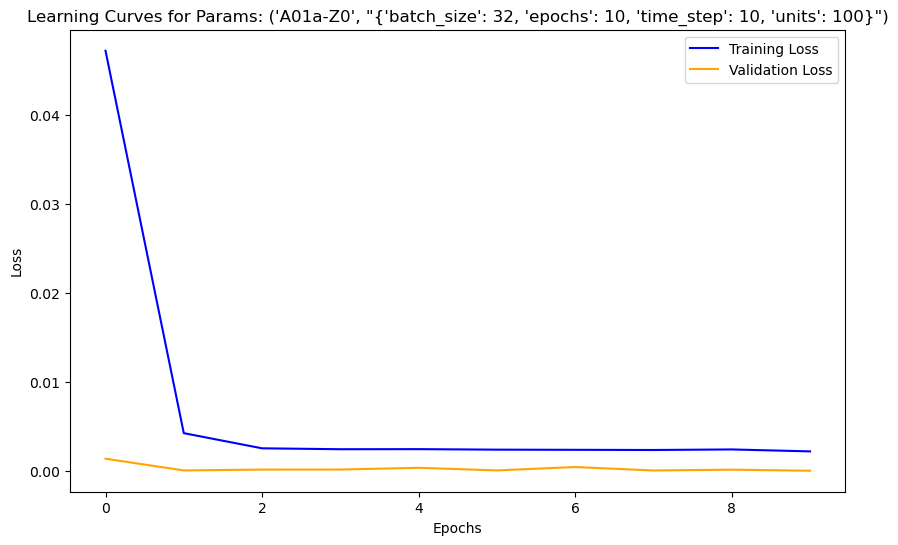

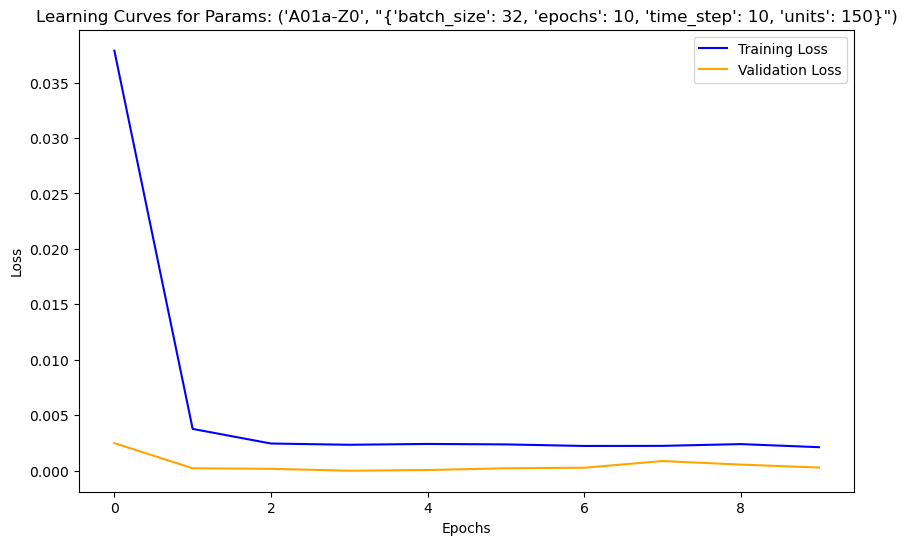

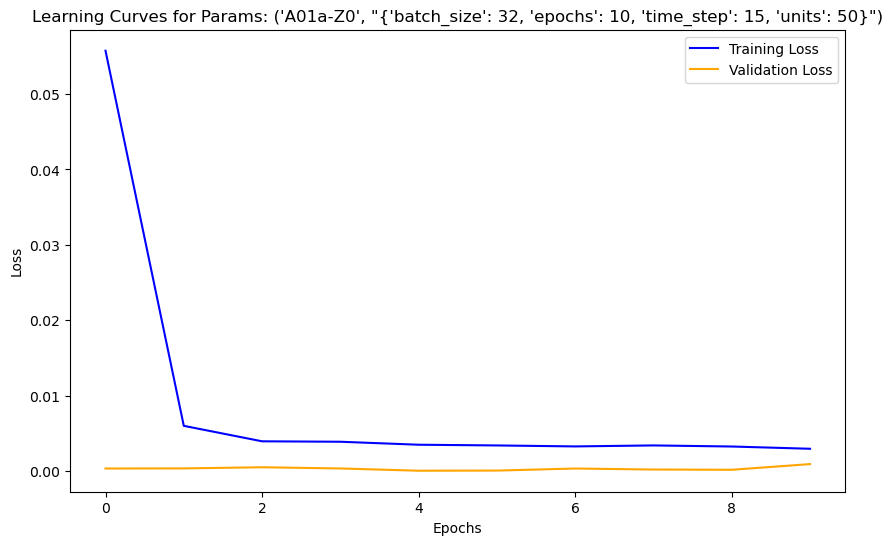

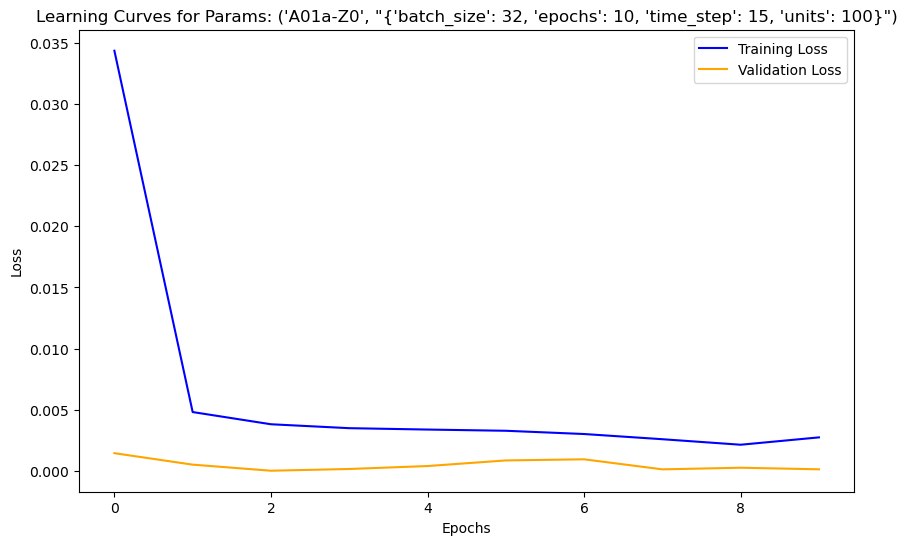

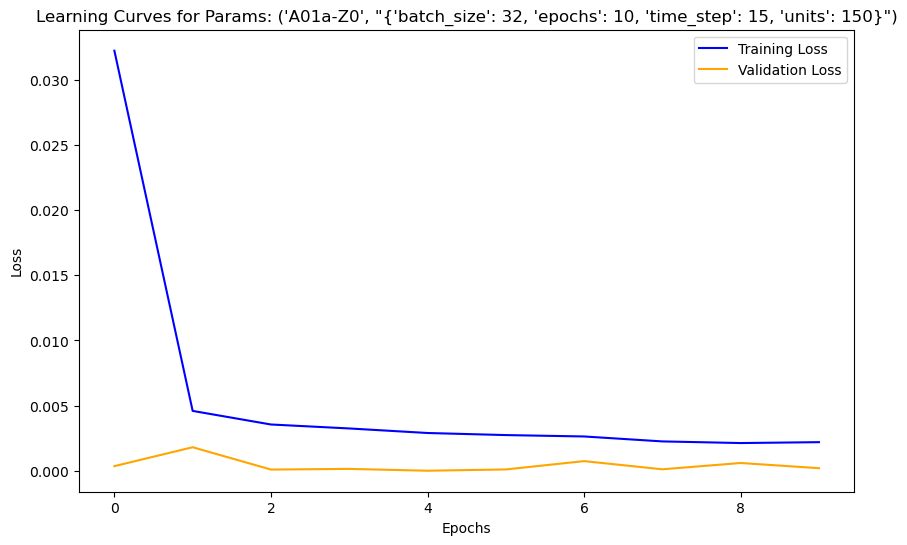

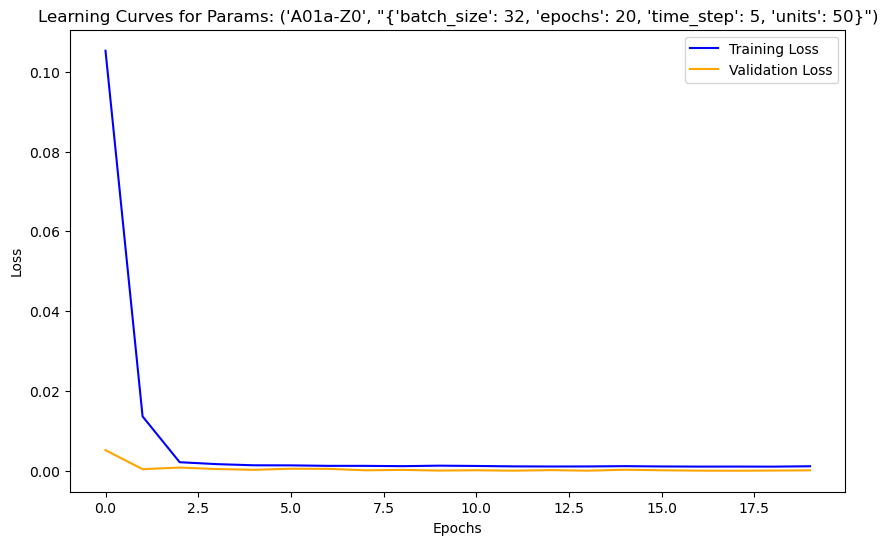

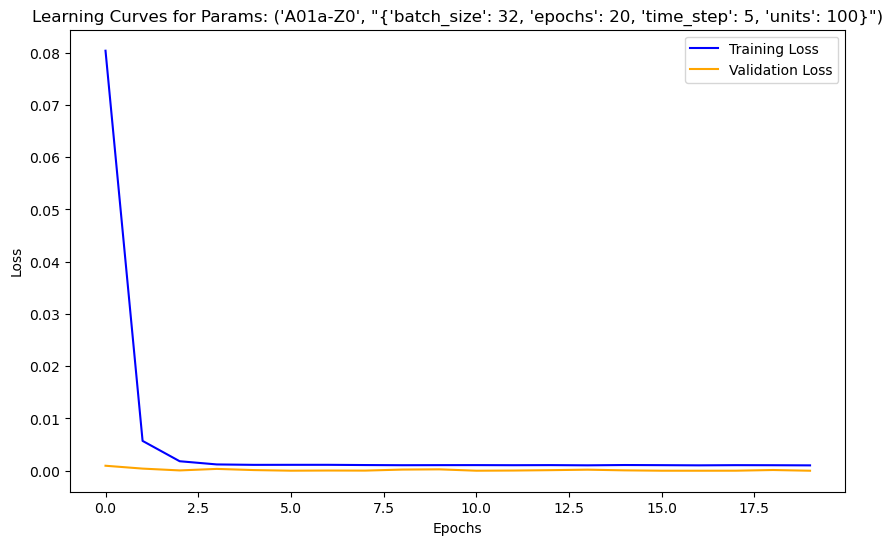

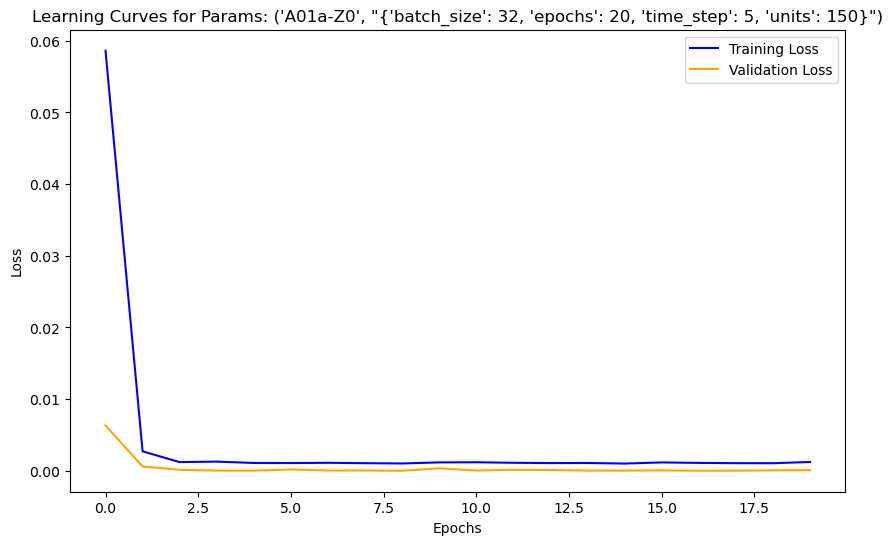

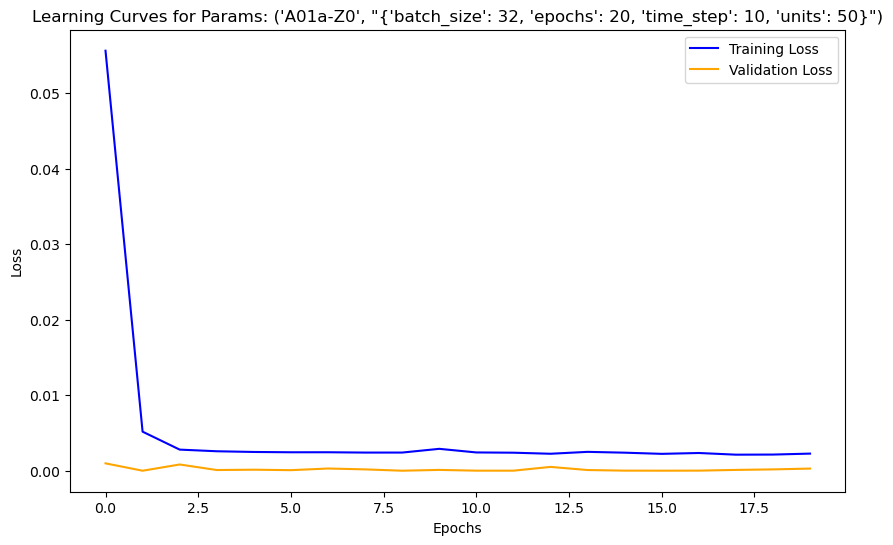

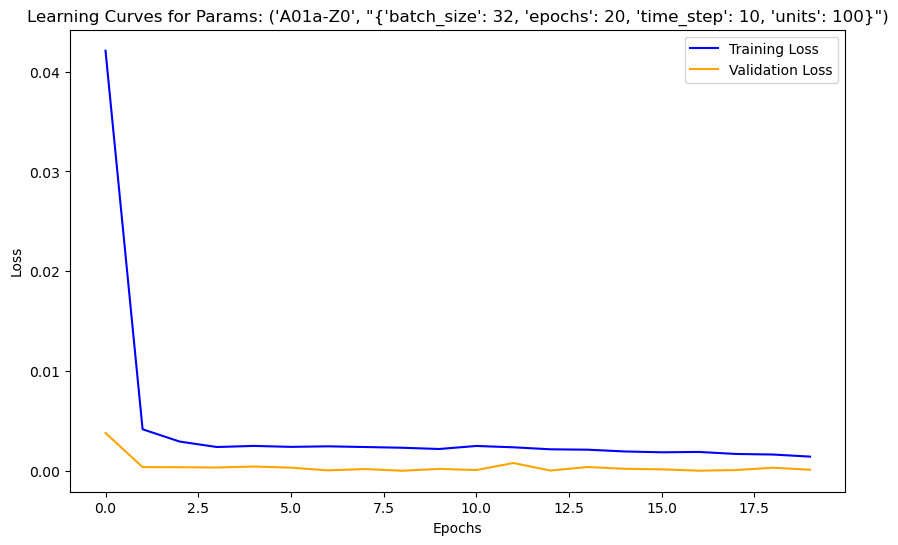

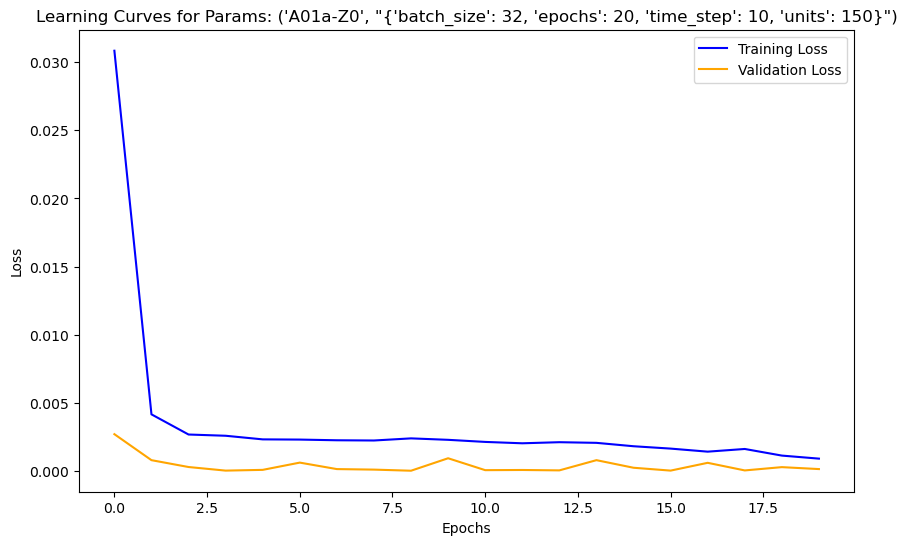

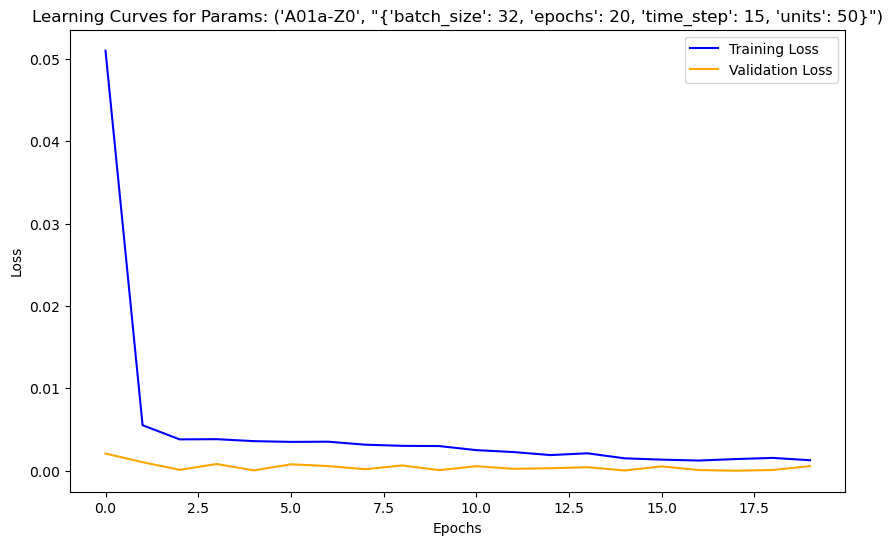

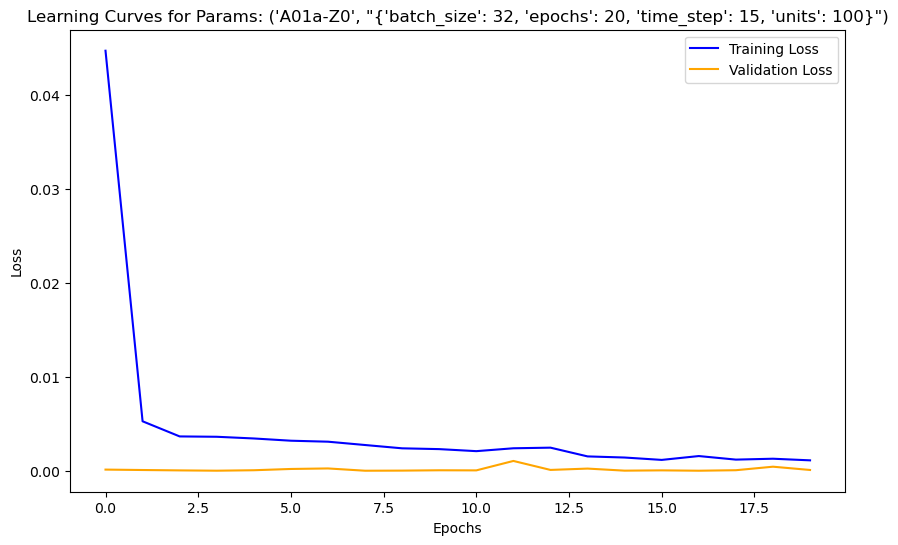

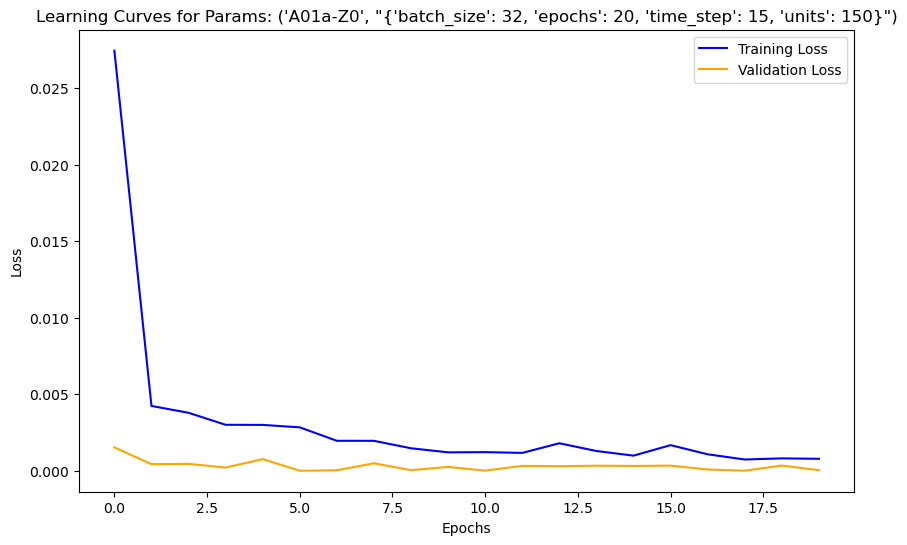

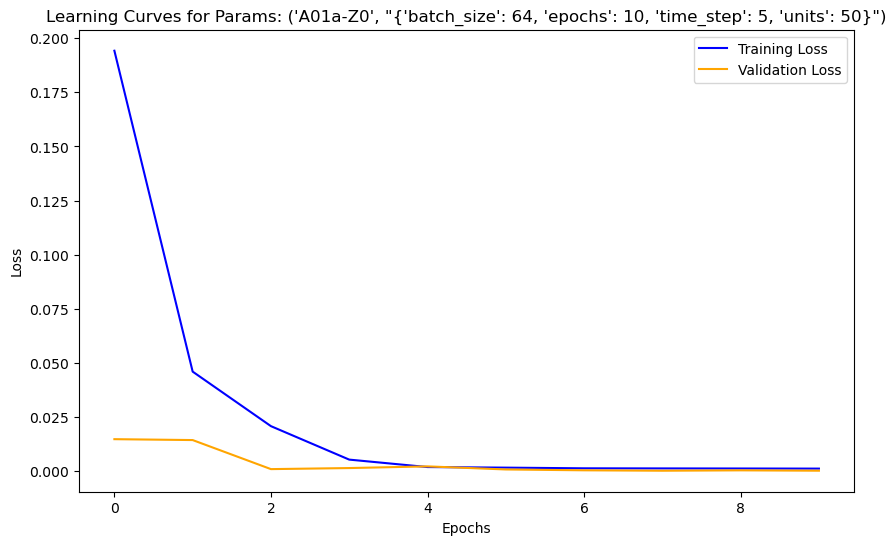

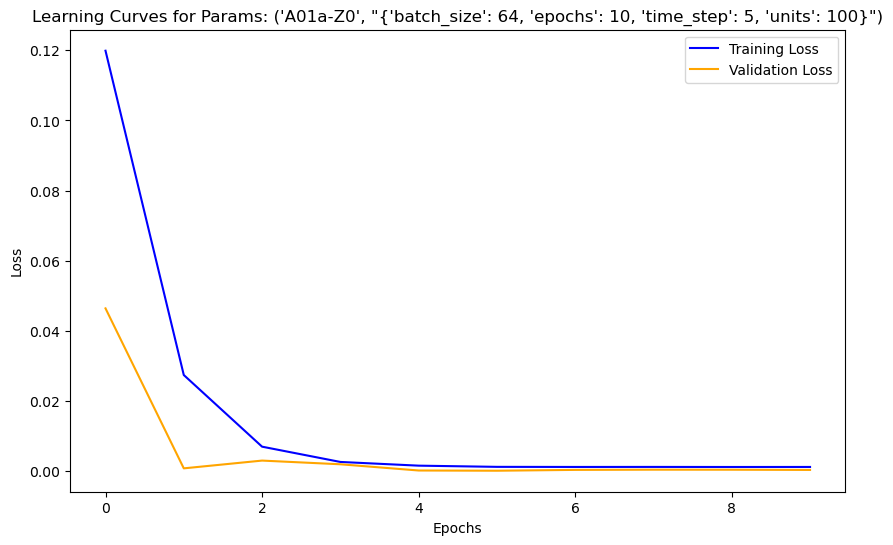

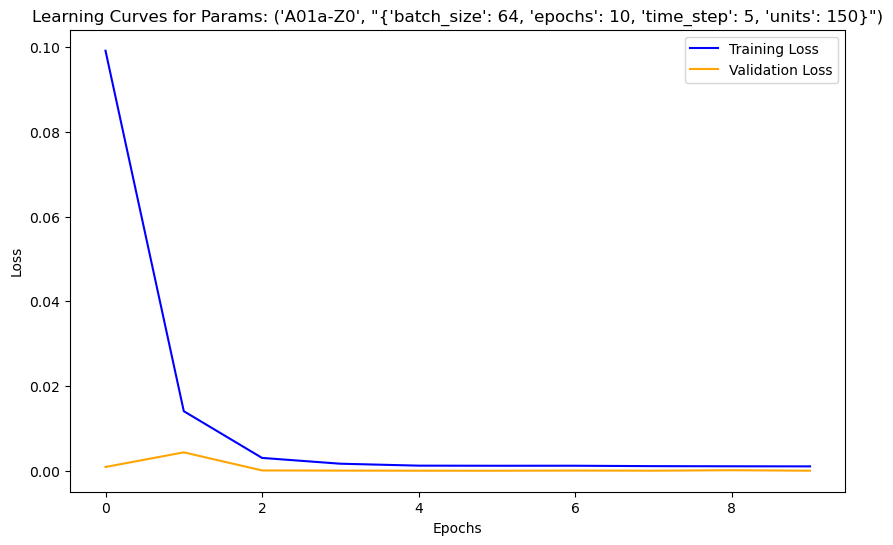

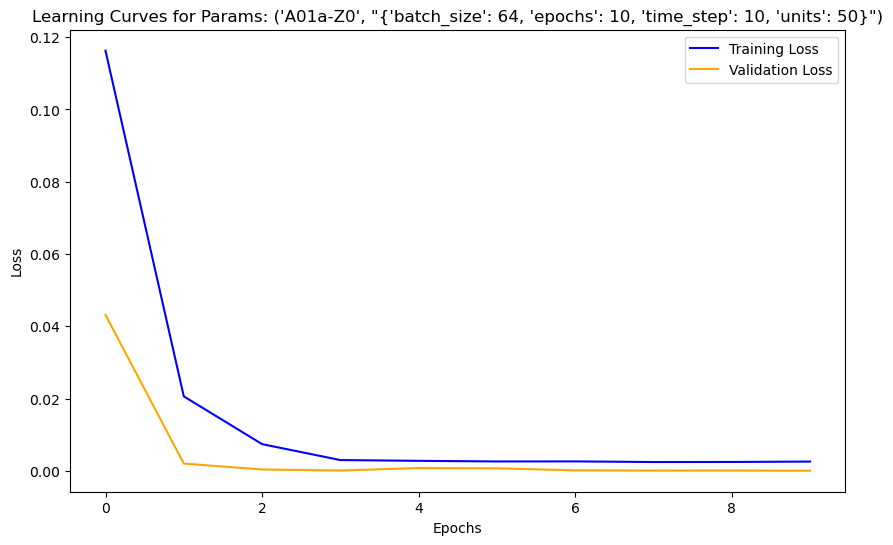

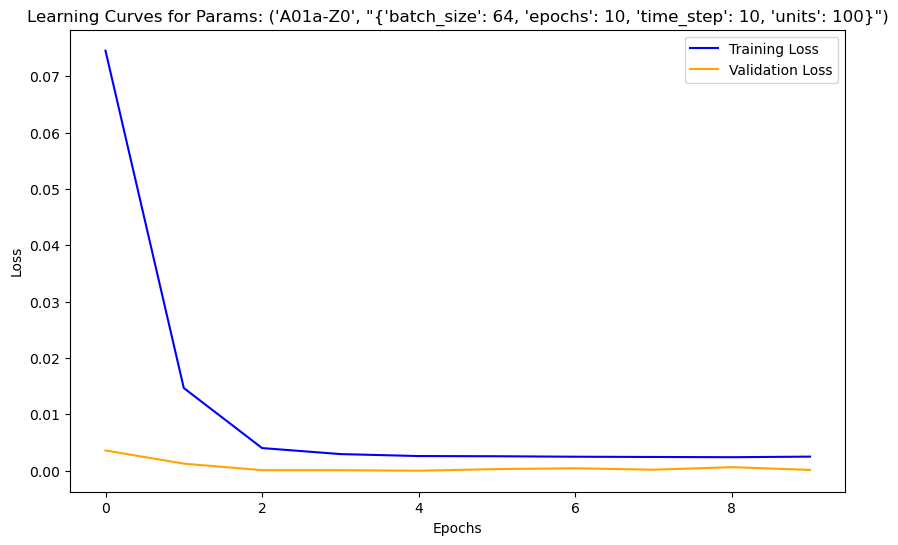

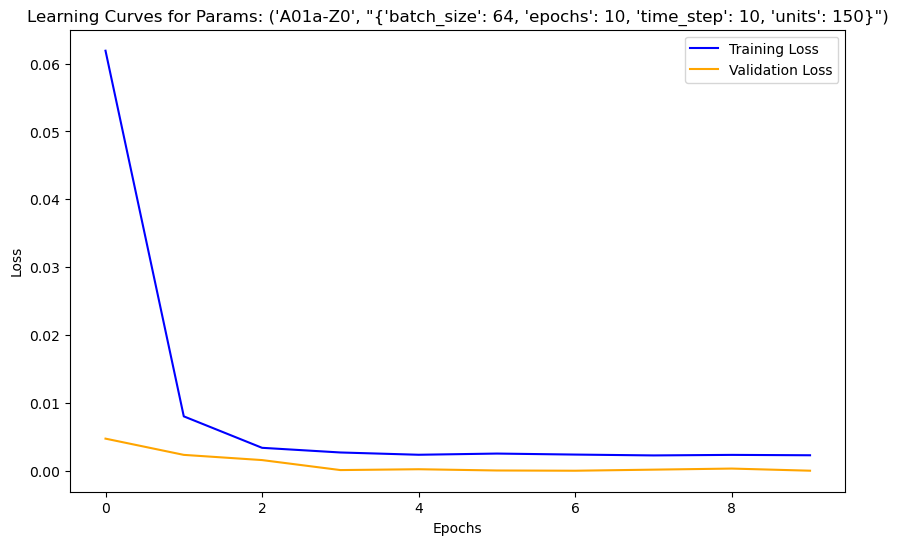

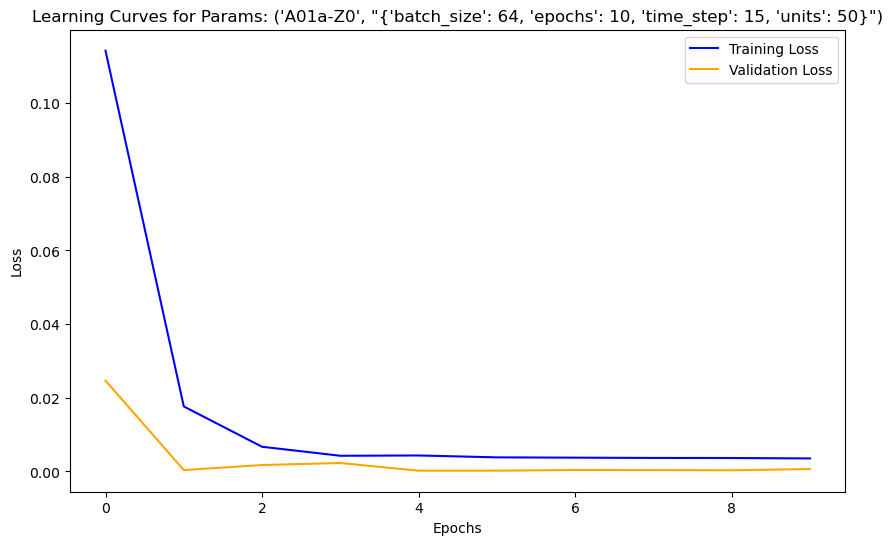

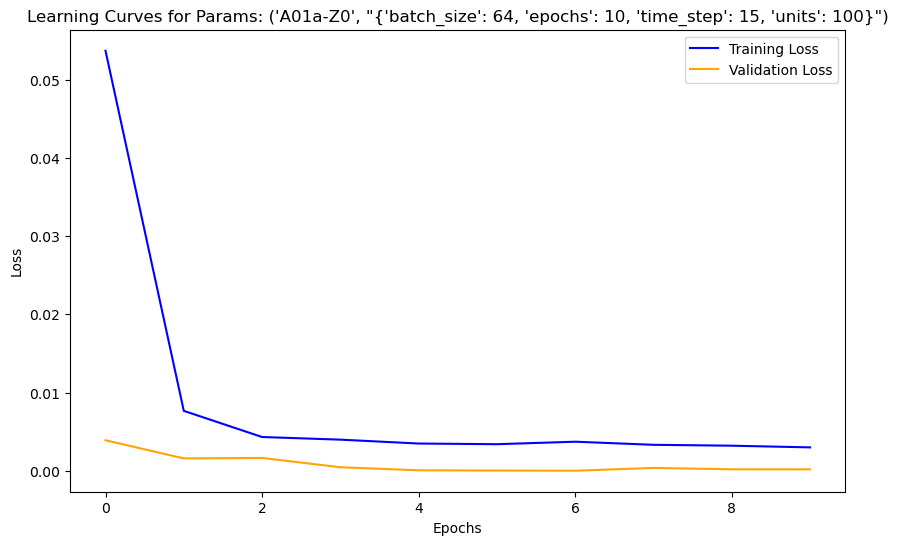

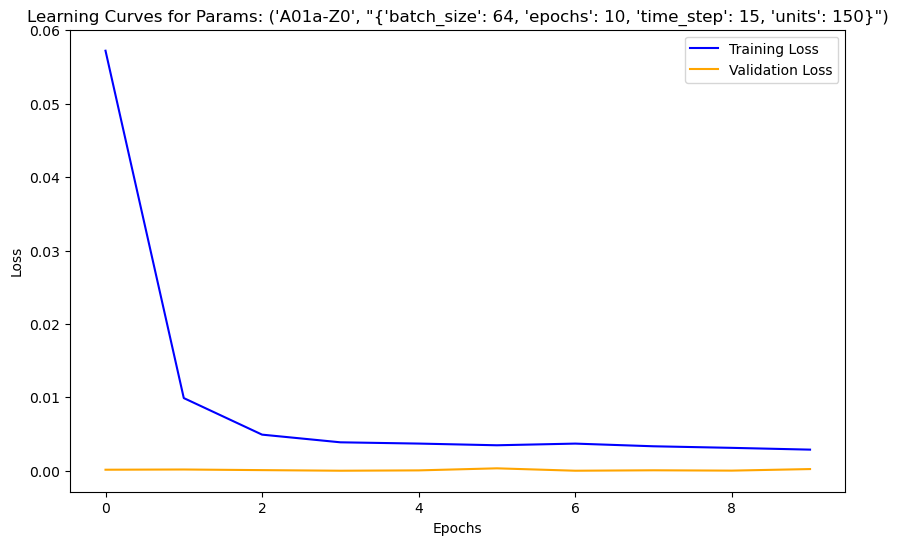

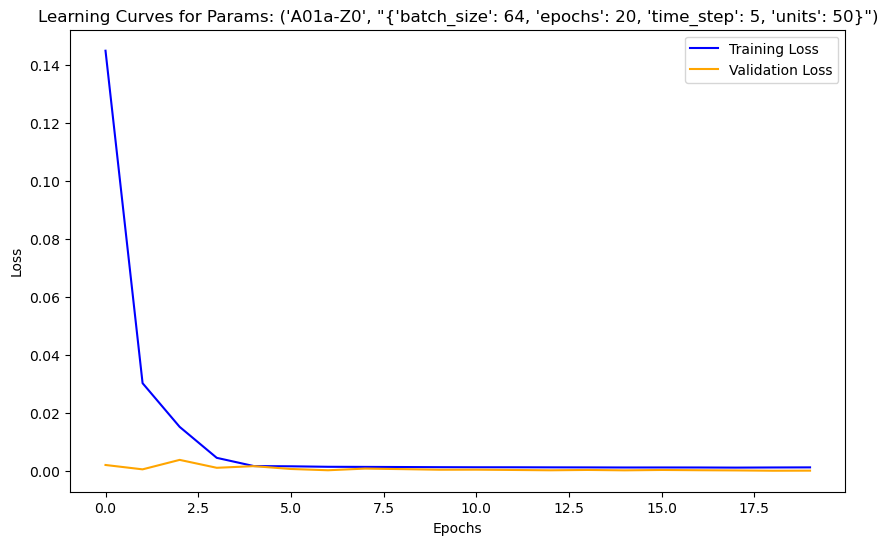

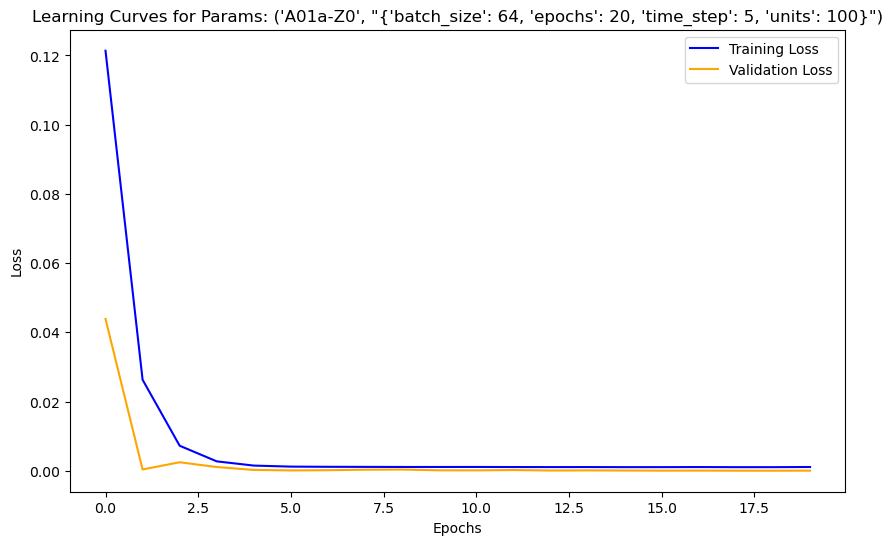

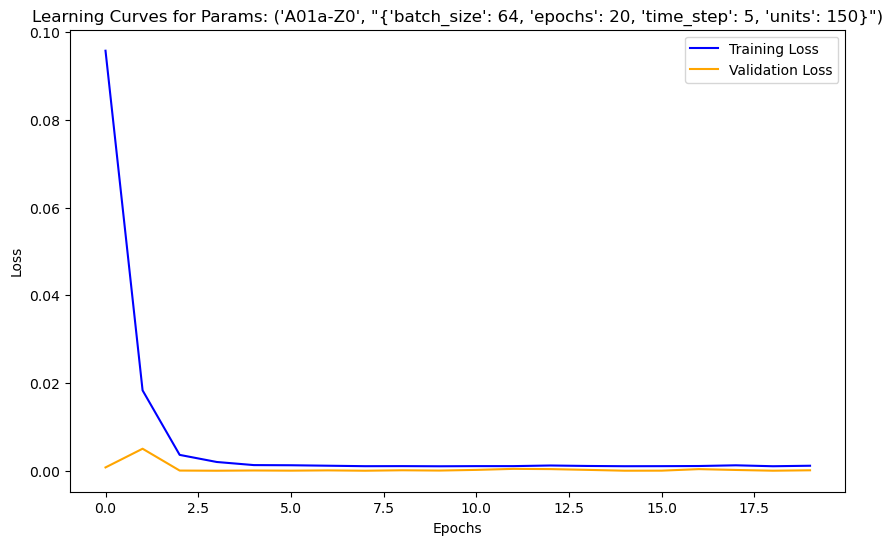

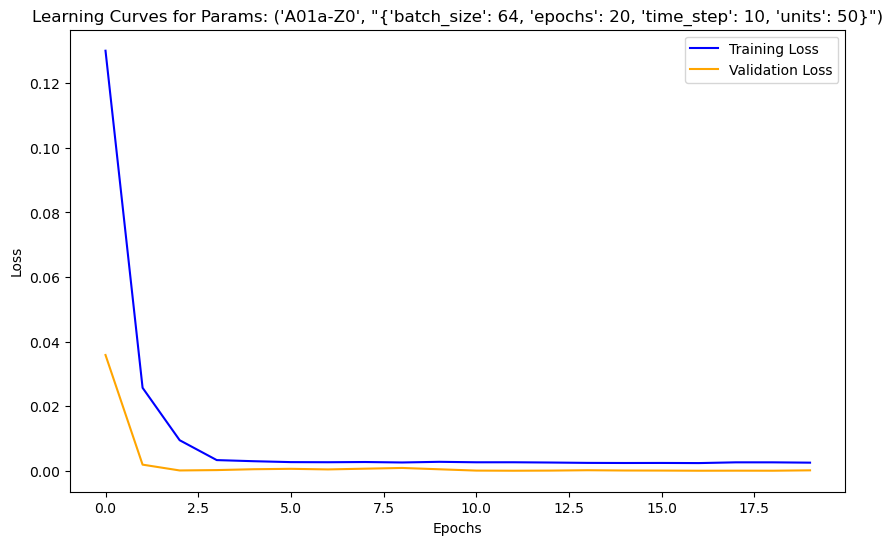

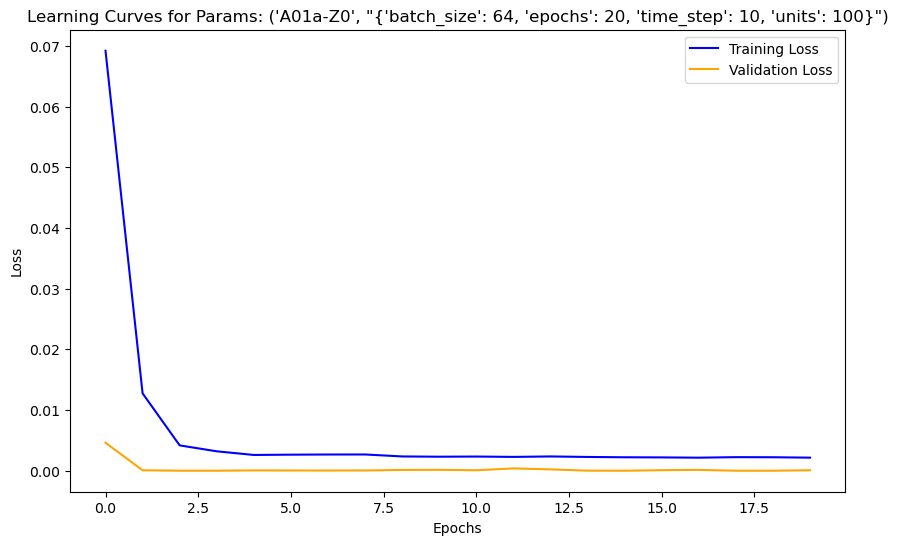

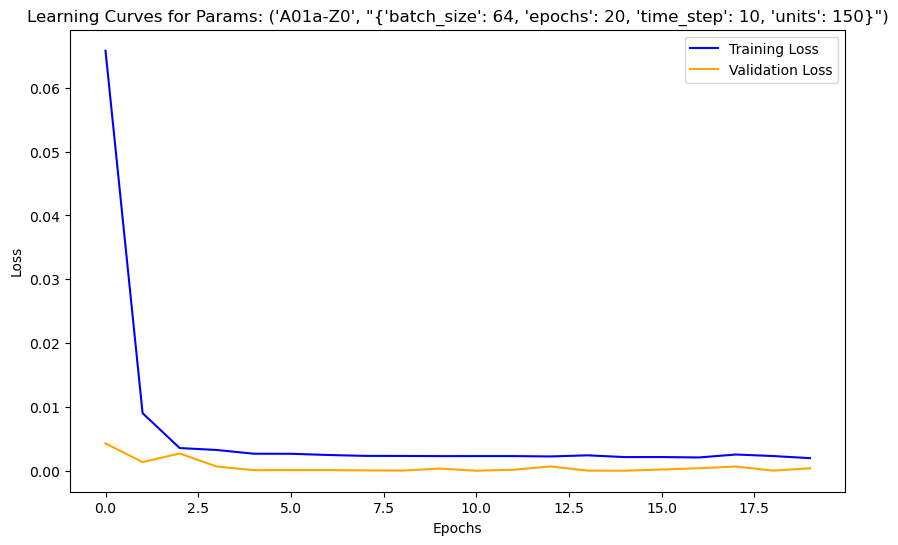

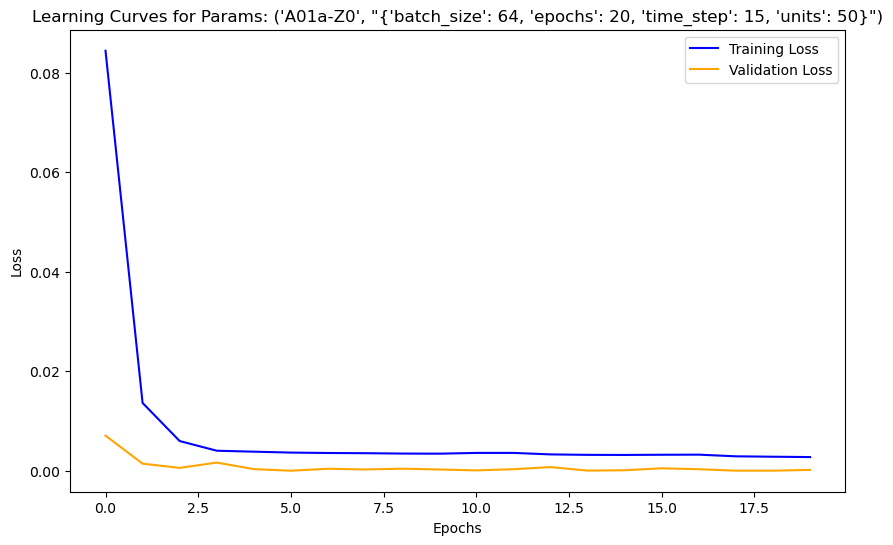

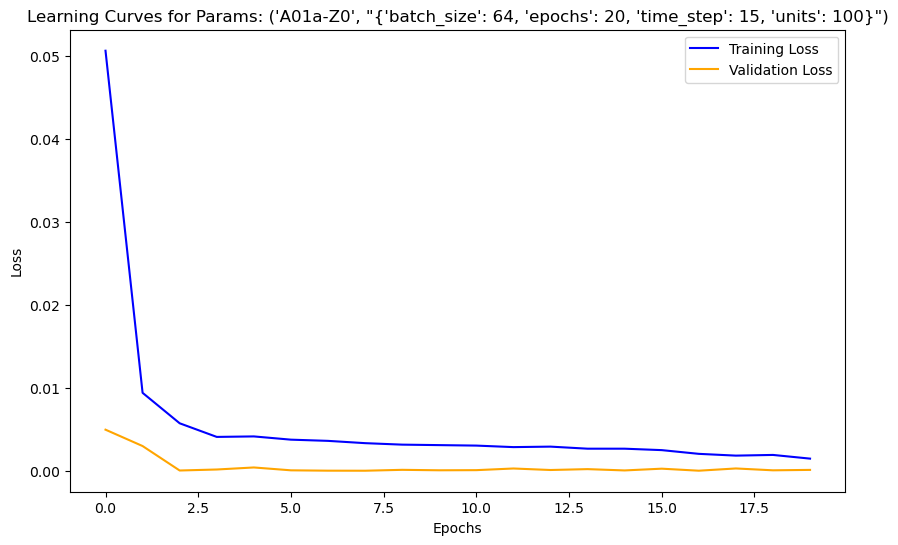

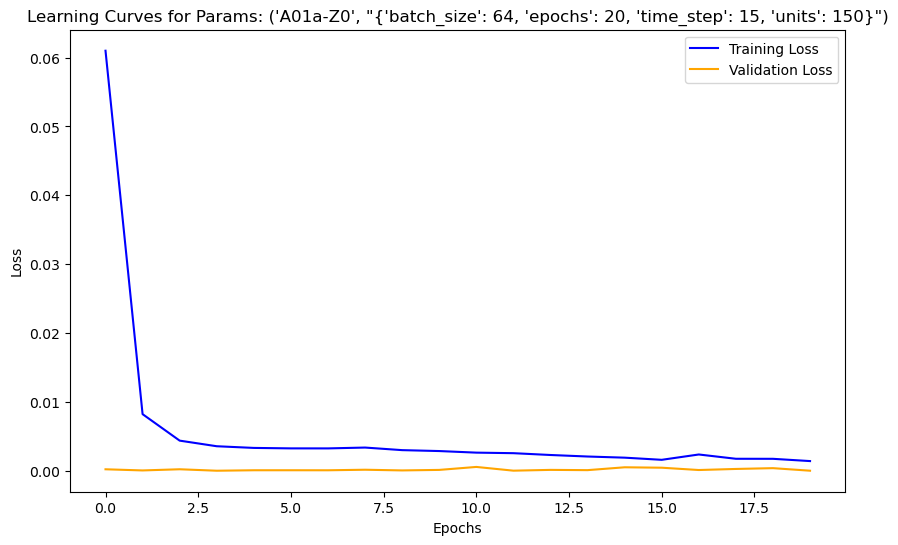

In [6]:
def create_folder():
    """
    create a folder that stores the learning curves for each hyperparameter set

    """
    if not os.path.exists('learning_curves'):
        os.makedirs('learning_curves')
    return None

# Loop through the histories dictionary to plot the training and validation loss
for param_set, history in histories.items():
    # Extract training and validation loss
    train_loss = history['loss']
    val_loss = history.get('val_loss', [])  # Validation loss (if available)

    # Create a new figure for each hyperparameter set
    plt.figure(figsize=(10, 6))

    # Plot the training loss
    plt.plot(train_loss, label='Training Loss', color='blue')

    # Plot the validation loss if available
    if val_loss:
        plt.plot(val_loss, label='Validation Loss', color='orange')

    # Add title and labels
    plt.title(f"Learning Curves for Params: {param_set}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Show the plot
    plt.show()

# Predict the columns based on the model

In [10]:
# Initialize a dictionary to store predictions
predictions = {}
time_step = best_params['time_step']
# Loop through each column in the dataset
for column in data.columns[1:]:
    print(f"Analayzing for column: {column}")
    # Scale the data for this column individually
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[[column]])  # Scaling each column individually
    
    # Create dataset for this column
    X, y = create_dataset(scaled_data, time_step)

    # Split into train and test sets (80% train, 20% test)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Reshape X to be in the form (samples, time_step, features)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Predict using the best_model
    print(f"Stared Training for {column}")
    train_predict = best_model.predict(X_train)
    print(f"Stared Testing for {column}")
    test_predict = best_model.predict(X_test)

    # Inverse transform the predictions and actual values back to original scale
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Store predictions for each column
    predictions[column] = {
        'train_predict': train_predict,
        'test_predict': test_predict,
        'y_test_rescaled': y_test_rescaled
    }

Analayzing for column: A01a-Z1
Stared Training for A01a-Z1
25/25 [==============================] - 0s 12ms/step
Stared Testing for A01a-Z1
7/7 [==============================] - 0s 8ms/step
Analayzing for column: A08a-Z0
Stared Training for A08a-Z0
25/25 [==============================] - 0s 10ms/step
Stared Testing for A08a-Z0
7/7 [==============================] - 0s 12ms/step
Analayzing for column: A08a-Z1
Stared Training for A08a-Z1
25/25 [==============================] - 0s 11ms/step
Stared Testing for A08a-Z1
7/7 [==============================] - 0s 9ms/step


# Now plot the results using the structure you provided


In [11]:
for column in data.columns[1:]:
    # Extract train/test predictions and true test values
    train_predict = predictions[column]['train_predict']
    test_predict = predictions[column]['test_predict']
    y_test_rescaled = predictions[column]['y_test_rescaled']

    # Calculate errors for test data (MAE)
    errors = np.abs(test_predict.flatten() - y_test_rescaled.flatten())

    # Create a figure with 1 row and 2 columns
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Predictions", "Errors"))

    # Plot train predictions
    fig.add_trace(go.Scatter(x=data.index[:len(train_predict)], y=train_predict.flatten(), 
                             mode='lines', name=f'Train Predictions {column}'), row=1, col=1)
    
    # Plot test predictions
    fig.add_trace(go.Scatter(x=data.index[len(train_predict):], y=test_predict.flatten(), 
                             mode='lines', name=f'Test Predictions {column}'), row=1, col=1)
    
    # Plot true values
    fig.add_trace(go.Scatter(x=data.index, y=data[column], 
                             mode='lines', name=f'True Values {column}'), row=1, col=1)

    # Plot the errors in the second subplot (right side)
    fig.add_trace(go.Scatter(x=data.index[len(train_predict):], y=errors, 
                             mode='lines', name=f'Errors {column}'), row=1, col=2)

    # Update layout for the figure
    fig.update_layout(title=f'LSTM Predictions and Errors for {column}',
                      height=800, width=1600,
                      xaxis_title="Time", 
                      yaxis_title="Values")

    # Show the plot
    fig.show()